In [1]:
import os
import sys
import warnings; warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd

%matplotlib inline

# feature_importance_
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier

In [2]:
# добавляем в sys.path директорию со скриптами
src_dir = os.path.join(os.getcwd(), '..', 'ocp')
sys.path.append(src_dir)

In [3]:
# загружаем необходимые скрипты
from data.loading import load_data
from features.feature_selection import correct_features_lists
from features.feature_engineering import count_row_nans
from plotting import plot_barplot

%load_ext autoreload
%autoreload

# задаем константы
SEED = 26

In [5]:
train, test, numerical, categorical = load_data('../data/intermediate')

In [6]:
numerical, categorical = numerical.tolist(), categorical.tolist()

# Добавление новых признаков

## Признаки, связанные с пропусками

In [7]:
nans = train.isna().mean()
nans.value_counts().sort_index().index[6:]

Float64Index([0.038675,   0.1004, 0.100425,   0.1049, 0.110875,    0.111,
                0.1454,   0.2777, 0.448425, 0.523375, 0.569425, 0.580375,
               0.74525],
             dtype='float64')

In [8]:
# на каждую такую группу признаков, имеющих
# одинаковое количество пропусков, создадим 
# признак-индикатор пропусков
nans_group = nans.value_counts().sort_index().index[6:]
for group in nans_group:
    feature = nans[nans == group].index[0]
    train[f'{group}_missing_indicator'] = train[feature].isna().map({True: 1, False: 0})
    test[f'{group}_missing_indicator'] = test[feature].isna().map({True: 1, False: 0})

In [9]:
# добавим в качестве нового признака
# число пропусков в строке
train['nans'] = count_row_nans(train)
test['nans'] = count_row_nans(test)

## Признаки, связанные со взаимодействием числовых признаков

In [10]:
diff_pairs = (['Var133', 'Var134'], ['Var133', 'Var163'], 
              ['Var133', 'Var38'], ['Var133', 'Var76'], 
              ['Var134', 'Var163'], ['Var134', 'Var38'], 
              ['Var134', 'Var76'], ['Var163', 'Var38'],
              ['Var163', 'Var76'], ['Var38', 'Var76'],
              ['Var38', 'Var94'])

ratio_pairs = (['Var73', 'Var126'], ['Var153', 'Var133'],
               ['Var153', 'Var134'], ['Var153', 'Var38'], 
               ['Var153', 'Var76'])

In [11]:
for pair in diff_pairs:
    first, second = pair
    train[first + '_' + second + '_diff'] = train[first] - train[second]
    test[first + '_' + second + '_diff'] = test[first] - test[second]

for pair in ratio_pairs:
    numerator, denominator = pair
    train[numerator + '_' + denominator + '_ratio'] = (train[numerator] + 1) / (train[denominator] + 1)
    test[numerator + '_' + denominator + '_ratio'] = (test[numerator] + 1) / (test[denominator] + 1)

In [12]:
train.columns

Index(['Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197', 'Var199',
       'Var201', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var218', 'Var219',
       'Var221', 'Var223', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229',
       'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var126',
       'Var13', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144',
       'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var189',
       'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57',
       'Var6', 'Var65', 'Var7', 'Var72', 'Var73', 'Var74', 'Var76', 'Var81',
       'Var83', 'Var85', 'Var94', 'target', '0.038675_missing_indicator',
       '0.1004_missing_indicator', '0.100425_missing_indicator',
       '0.1049_missing_indicator', '0.110875_missing_indicator',
       '0.111_missing_indicator', '0.1454_missing_indicator',
       '0.2777_missing_indicator', '0.44

In [13]:
new_features = ['0.038675_missing_indicator', '0.1004_missing_indicator', 
                '0.100425_missing_indicator', '0.1049_missing_indicator', 
                '0.110875_missing_indicator', '0.111_missing_indicator', 
                '0.1454_missing_indicator', '0.2777_missing_indicator', 
                '0.448425_missing_indicator', '0.523375_missing_indicator', 
                '0.569425_missing_indicator', '0.580375_missing_indicator', 
                '0.74525_missing_indicator', 'nans',
                'Var133_Var134_diff', 'Var133_Var163_diff', 
                'Var133_Var38_diff', 'Var133_Var76_diff', 
                'Var134_Var163_diff', 'Var134_Var38_diff', 
                'Var134_Var76_diff', 'Var163_Var38_diff', 
                'Var163_Var76_diff', 'Var38_Var76_diff', 
                'Var38_Var94_diff', 'Var73_Var126_ratio',
                'Var153_Var133_ratio', 'Var153_Var134_ratio', 
                'Var153_Var38_ratio', 'Var153_Var76_ratio']

numerical = np.union1d(numerical, new_features).tolist()

# выводим данные об изменении длины списка числовых переменных
print('After correction: numerical -', len(numerical))

After correction: numerical - 70


## Отбор признаков с помощью feature_importance

In [14]:
# зададим определенный порядок переменных
train = train[categorical + numerical + ['target']]
test = test[categorical + numerical]

In [15]:
# разделим матрицу признаков и целевую переменную из данных обучения
X, y = (train.drop(['target'], axis=1), 
        train.target)

X.fillna(-999999999, inplace=True)

# отложим часть выборки для финальной оценки модели
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, 
                                                          test_size=0.33, 
                                                          stratify=y,
                                                          random_state=SEED)

model = CatBoostClassifier(learning_rate=0.1, n_estimators=100, random_state=SEED)
model.fit(X_train, y_train, cat_features=categorical, verbose=False);

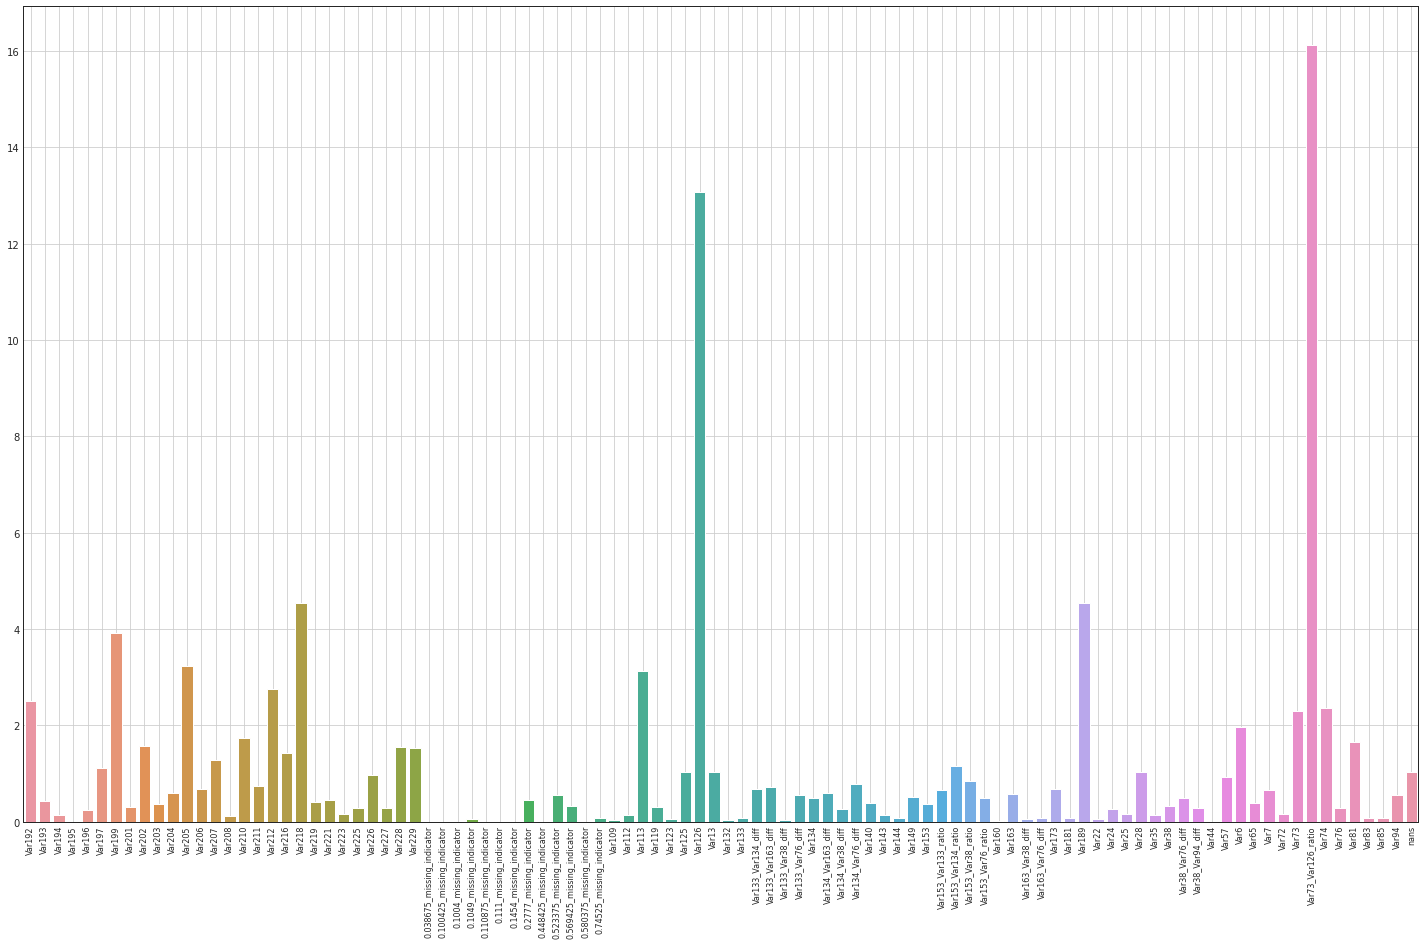

In [16]:
plot_barplot(x=X_train.columns, y=model.feature_importances_, figsize=(25, 15))

In [17]:
selected = X_train.columns[model.feature_importances_ != 0]
selected

Index(['Var192', 'Var193', 'Var194', 'Var195', 'Var196', 'Var197', 'Var199',
       'Var201', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var218', 'Var219',
       'Var221', 'Var223', 'Var225', 'Var226', 'Var227', 'Var228', 'Var229',
       '0.1049_missing_indicator', '0.2777_missing_indicator',
       '0.523375_missing_indicator', '0.569425_missing_indicator',
       '0.74525_missing_indicator', 'Var109', 'Var112', 'Var113', 'Var119',
       'Var123', 'Var125', 'Var126', 'Var13', 'Var132', 'Var133',
       'Var133_Var134_diff', 'Var133_Var163_diff', 'Var133_Var38_diff',
       'Var133_Var76_diff', 'Var134', 'Var134_Var163_diff',
       'Var134_Var38_diff', 'Var134_Var76_diff', 'Var140', 'Var143', 'Var144',
       'Var149', 'Var153', 'Var153_Var133_ratio', 'Var153_Var134_ratio',
       'Var153_Var38_ratio', 'Var153_Var76_ratio', 'Var160', 'Var163',
       'Var163_Var38_diff', 'Var163_Var76_diff', 'Var173', 'Var18

In [18]:
# скорректируем имеющиеся списки числовых и категориальных признаков
numerical, categorical = correct_features_lists(selected, numerical, categorical)

After correction: numerical - 61 , categorical: -  28 



In [19]:
# зададим определенный порядок переменных
train = train[categorical + numerical + ['target']]
test = test[categorical + numerical]

In [20]:
# сохраним обработанные данные, а также списки переменных
train.to_csv('../data/processed/train.csv')
test.to_csv('../data/processed/test.csv')
np.save('../data/processed/numerical.npy', numerical)
np.save('../data/processed/categorical.npy', categorical)